# Battle of the Neighbors

### Part 1: Download and explore data for New York City, Manhattan and Toronto using geographical co-ordinates

To explore the dataset, we have used latitude and longitude data for each geographic location and visualised it using Folium

Let us import all the required libraries and dependancies

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium

import csv

print('Download complete')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / ^C
failed

CondaError: KeyboardInterrupt

     |████████████████████████████████| 79 kB 8.1 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=5d28540766f35d6ab6a6f1bc2937a7a73447a9bcd17955afd022ad90b199148a
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Download complete


Let us download the data from 

In [5]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


# New York City

### Let us start by loading and exploring data for New York City

In [6]:
with open('newyork_data.json') as json_data:
    newyork_data=json.load(json_data)

All the relevant data is in the features key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.

In [7]:
neighborhoods_data=newyork_data['features']

Take a look at the first item in this list.

In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Let us transform the data in a pandas dataframe

In [10]:
column_names=['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods=pd.DataFrame(columns=column_names)

In [11]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Let us loop the data and fill the dataframe

In [13]:
for data in neighborhoods_data:
    borough=neighborhood_name=data['properties']['borough']
    neighborhood_name=data['properties']['name']
    
    neighborhood_latlon=data['geometry']['coordinates']
    neighborhood_lat=neighborhood_latlon[1]
    neighborhood_lon=neighborhood_latlon[0]
    
    neighborhoods=neighborhoods.append({'Borough':borough, 
                                        'Neighborhood':neighborhood_name, 
                                        'Latitude':neighborhood_lat, 
                                        'Longitude':neighborhood_lon}, ignore_index=True)

In [14]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let us check the number of boroughs and neighbothoods in the dataframe

In [16]:
print('The dataframe has {} boroughs and {} neighborhoods'.format(len(neighborhoods['Borough'].unique()), neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods


In [17]:
neighborhoods.to_csv('NYC_GEODATA.csv', index=False)

#### Use geopy to get latitude and longitude data of NYC

In [18]:
address= 'New York City, NY'

geolocator=Nominatim(user_agent="ny_explorer")
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geographical coordinates of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinates of New York City are 40.7127281, -74.0060152.


#### Create a map of New York City with neighborhoods superimposed on top

Folium is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [20]:
map_newyork=folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label='{}, {}'.format(neighborhood, borough)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#318cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)
    
map_newyork

### Segmenting and Clustering the Data

In this section of the capstone project, we will use the Foursquare API to explore neighborhoods in Manhattan. We will use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Manhattan and their emerging clusters.

Let us find the number of boroughs in NYC

In [21]:
neighborhoods['Borough'].value_counts().to_frame()

,Borough
Queens,81
Brooklyn,70
Staten Island,63
Bronx,52
Manhattan,40


In [22]:
neighborhoods.shape

(306, 4)

Defining foursquare credentials

In [23]:
CLIENT_ID='ZBOGAXS2QOGAQYNED4CVIAJAFVXSEB3BAPJTZ5NVA1FV5SDI'
CLIENT_SECRET='SQOYKEXCZMXG5SIXXTVD5DNPWB501E0VVEAPUMITTANEQTIY'
VERSION='20180605'

Lets explore neighborhoods in New York City

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
NYC_venues=getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [31]:
print(NYC_venues.shape)
NYC_venues.head()

(10040, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place


#### The number of neighborhoods in NYC is 10,040, which is very large compared to the Toronto datasert. So let us slice the data to explore only the Manhattan region from NYC

## Manhattan

In [32]:
manhattan_data=neighborhoods[neighborhoods['Borough']=='Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Lets get the geographical co-ordinates of Manhattan

In [33]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### Lets create a map of Manhattan using Folium

In [34]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
manhattan_venues=getNearbyVenues(names=manhattan_data['Neighborhood'], latitudes=manhattan_data['Latitude'], longitudes=manhattan_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Now lets check the size of the dataframe for Manhattan

In [40]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3183, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


#### The number of venues in Manhattan is 3,183, which is considerably less than entire NYC, and comparable with Toronto data

Let's check how many venues were returned for each neighborhood

In [42]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Carnegie Hill,90,90,90,90,90,90
Central Harlem,42,42,42,42,42,42
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [43]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 331 uniques categories.


Analyse each neighborhood using onehot encoding

In [44]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke S

In [45]:
manhattan_onehot.shape

(3183, 332)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [47]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke S

In [48]:
#lets confirm the new size
manhattan_grouped.shape

(40, 332)

Let's print each neighborhood along with the top 5 most common venues

In [49]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
            venue  freq
0     Coffee Shop  0.07
1  Clothing Store  0.05
2           Hotel  0.05
3             Gym  0.05
4            Park  0.05


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.08
1            Café  0.04
2  Cosmetics Shop  0.04
3     Yoga Studio  0.03
4             Gym  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1                  Bar  0.05
2   Seafood Restaurant  0.05
3  American Restaurant  0.05
4   Chinese Restaurant  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.06
1               Bakery  0.05
2  American Restaurant  0.04
3          Art Gallery  0.04
4   Italian Restaurant  0.03


----Chinatown----
                venue  freq
0              Bakery  0.08
1  Chinese Restaurant  0.08
2        Cocktail Bar  0.04
3   Hotpot Restaurant  0.04
4  Salon / Barbershop  0.03


----Civic Center----
                 venue  freq
0          Coffee Shop  0.08
1 

Let's put that into a pandas dataframe

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_venues_sorted = pd.DataFrame(columns=columns)
manhattan_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Clothing Store,Hotel,Park,Gym,Memorial Site,Gourmet Shop,Burger Joint,Beer Garden,Food Court
1,Carnegie Hill,Coffee Shop,Cosmetics Shop,Café,Yoga Studio,Bookstore,Gym,French Restaurant,Pizza Place,Wine Shop,Bakery
2,Central Harlem,African Restaurant,French Restaurant,Chinese Restaurant,American Restaurant,Cosmetics Shop,Seafood Restaurant,Bar,Southern / Soul Food Restaurant,Gym,Ethiopian Restaurant
3,Chelsea,Coffee Shop,Bakery,American Restaurant,Art Gallery,French Restaurant,Seafood Restaurant,Italian Restaurant,Ice Cream Shop,Hotel,Park
4,Chinatown,Bakery,Chinese Restaurant,Hotpot Restaurant,Cocktail Bar,Optical Shop,Spa,Dessert Shop,American Restaurant,Salon / Barbershop,Shanghai Restaurant


Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [54]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 1, 1, 3, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [55]:
manhattan_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

manhattan_merged = manhattan_merged.join(manhattan_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Gym,Discount Store,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,0,Bakery,Chinese Restaurant,Hotpot Restaurant,Cocktail Bar,Optical Shop,Spa,Dessert Shop,American Restaurant,Salon / Barbershop,Shanghai Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Mobile Phone Shop,Bank,Park,New American Restaurant,Coffee Shop,Grocery Store,Gym,Deli / Bodega
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Restaurant,Lounge,Café,Wine Bar,Pizza Place,Park,Bakery,Deli / Bodega,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Yoga Studio,Caribbean Restaurant,Chinese Restaurant,School,Sandwich Place


Let's visualize the resulting clusters

In [56]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examin Clusters

#### Cluster 1

In [57]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Bakery,Chinese Restaurant,Hotpot Restaurant,Cocktail Bar,Optical Shop,Spa,Dessert Shop,American Restaurant,Salon / Barbershop,Shanghai Restaurant
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Bank,Park,New American Restaurant,Coffee Shop,Grocery Store,Gym,Deli / Bodega
4,Hamilton Heights,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Yoga Studio,Caribbean Restaurant,Chinese Restaurant,School,Sandwich Place
6,Central Harlem,African Restaurant,French Restaurant,Chinese Restaurant,American Restaurant,Cosmetics Shop,Seafood Restaurant,Bar,Southern / Soul Food Restaurant,Gym,Ethiopian Restaurant
9,Yorkville,Italian Restaurant,Gym,Coffee Shop,Bar,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Wine Shop,Diner,Japanese Restaurant
12,Upper West Side,Café,Italian Restaurant,Bar,Bakery,Wine Bar,Coffee Shop,Pizza Place,Indian Restaurant,Bagel Shop,Mediterranean Restaurant
17,Chelsea,Coffee Shop,Bakery,American Restaurant,Art Gallery,French Restaurant,Seafood Restaurant,Italian Restaurant,Ice Cream Shop,Hotel,Park
18,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,Gym,Café,American Restaurant,Indian Restaurant,Dessert Shop,Coffee Shop,Gourmet Shop
19,East Village,Bar,Pizza Place,Korean Restaurant,Cocktail Bar,Speakeasy,Wine Bar,Vietnamese Restaurant,Italian Restaurant,Ice Cream Shop,Mexican Restaurant
20,Lower East Side,Chinese Restaurant,Art Gallery,Café,Bakery,Pizza Place,Yoga Studio,Clothing Store,Speakeasy,Bubble Tea Shop,French Restaurant


#### Cluster 2

In [63]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Gym,Discount Store,Sandwich Place,Coffee Shop,Yoga Studio,Deli / Bodega,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
8,Upper East Side,Exhibit,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Bakery,American Restaurant,Yoga Studio,Pizza Place,Hotel,Juice Bar
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Burger Joint,Café,Gym / Fitness Center,Gym,Playground
13,Lincoln Square,Plaza,Café,Concert Hall,Performing Arts Venue,Theater,Gym / Fitness Center,French Restaurant,Wine Shop,Indie Movie Theater,Italian Restaurant
14,Clinton,Italian Restaurant,Gym / Fitness Center,American Restaurant,Theater,Coffee Shop,Hotel,Gym,Cocktail Bar,Sandwich Place,Wine Shop
15,Midtown,Hotel,Theater,Sporting Goods Shop,Bakery,Clothing Store,Steakhouse,Bookstore,Coffee Shop,American Restaurant,Cuban Restaurant
16,Murray Hill,Hotel,Coffee Shop,Gym / Fitness Center,Bar,Japanese Restaurant,Sandwich Place,Burger Joint,Sushi Restaurant,American Restaurant,Italian Restaurant
21,Tribeca,Park,Italian Restaurant,American Restaurant,Wine Bar,Spa,Coffee Shop,Café,Greek Restaurant,Poke Place,Bakery
24,West Village,Italian Restaurant,Cocktail Bar,New American Restaurant,Park,Wine Bar,American Restaurant,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Jazz Club
28,Battery Park City,Coffee Shop,Clothing Store,Hotel,Park,Gym,Memorial Site,Gourmet Shop,Burger Joint,Beer Garden,Food Court


#### Cluster 3

In [65]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Boat or Ferry,Park,Coffee Shop,Bar,Gym / Fitness Center,Harbor / Marina,Heliport,Bistro,Farmers Market,Pet Service


#### Cluster 4

In [66]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Restaurant,Lounge,Café,Wine Bar,Pizza Place,Park,Bakery,Deli / Bodega,Chinese Restaurant
5,Manhattanville,Seafood Restaurant,Coffee Shop,Deli / Bodega,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Fried Chicken Joint,Lounge,Boutique,Supermarket
7,East Harlem,Mexican Restaurant,Thai Restaurant,Bakery,Spa,Deli / Bodega,Latin American Restaurant,Sandwich Place,Restaurant,Liquor Store,Café
11,Roosevelt Island,Deli / Bodega,Park,Food & Drink Shop,Farmers Market,Coffee Shop,Moving Target,Greek Restaurant,Outdoors & Recreation,Gym,Gym / Fitness Center
26,Morningside Heights,American Restaurant,Park,Coffee Shop,Bookstore,Café,Burger Joint,Sandwich Place,Spa,Ethiopian Restaurant,Tennis Court
36,Tudor City,Park,Mexican Restaurant,Café,Greek Restaurant,Deli / Bodega,Diner,Gym,Coffee Shop,Dog Run,Pizza Place


#### Cluster 5

In [67]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Hotel Bar,Japanese Restaurant,Café,Dessert Shop,Coffee Shop,Gym / Fitness Center,Gastropub,Ramen Restaurant


# Toronto

#### Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

In [68]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [69]:
url= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data=requests.get(url).text


In [70]:
soup=BeautifulSoup(html_data, 'xml')

In [71]:
table=soup.find('table')

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [73]:
column_names= ['Postalcode', 'Borough', 'Neighborhood']
df=pd.DataFrame(columns = column_names)

In [74]:
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [75]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Cleaning the data. Removing rows where borough is 'Not assigned'

In [76]:
df=df[df['Borough']!='Not assigned']
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [77]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'}, inplace=True)

In [79]:
df_merge=pd.merge(df, temp_df, on='Postalcode')

In [80]:
df_merge.drop(['Neighborhood'], axis=1, inplace=True)
df_merge.drop_duplicates(inplace=True)

In [81]:
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'}, inplace=True)

In [82]:
df_merge.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [83]:
df_merge.shape

(103, 3)

#### Getting latitude and longitude coordinates for each location in order to use Foursquare location data

In [84]:
def get_geocode(postal_code):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]

In [85]:
import pandas as pd
geo_df=pd.read_csv('https://cocl.us/Geospatial_data')
geo_df.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [86]:
geo_df.rename(columns={'Postal Code':'Postalcode'}, inplace=True)
geo_merged=pd.merge(geo_df, df_merge, on='Postalcode')

In [87]:
geo_data=geo_merged[['Postalcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
geo_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Explore and cluster the neighborhoods in Toronto

In [88]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


#### Let's create a function to repeat the same process to all the neighborhoods

In [90]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venue_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        results=requests.get(url).json()["response"]['groups'][0]['items']
        
        venue_list.append([(
            name, 
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues=pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

In [91]:
toronto_venues=getNearbyVenues(names=toronto_data['Neighborhood'], latitudes=toronto_data['Latitude'], longitudes=toronto_data['Longitude'])


The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

Checking the size of the resulting dataframe

In [93]:
print(toronto_venues.shape)
toronto_venues.head()


(1602, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant


In [94]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,59,59,59,59,59,59
Christie,15,15,15,15,15,15
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,32,32,32,32,32,32


Let's find out how many unique categories can be curated from all the returned venues

In [96]:
print("There are {} unique categories.".format(len(toronto_venues['Venue Category'].unique())))

There are 230 unique categories.


Analysing each neighborhood using onehot encoding

In [97]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [98]:
toronto_onehot.shape

(1602, 230)

In [407]:
toronto_grouped=toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.000000,0.0,0.0,0.017241,0.051724,0.000000,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.0,0.017241,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.017241,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000,0.017241,0.051724,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.017241,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.

In [408]:
toronto_grouped.shape

(39, 230)

Let's print each neighborhood along with the top 5 most common venues

In [409]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp=toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns=['venues', 'freq']
    temp=temp.iloc[1:]
    temp['freq']=temp['freq'].astype(float)
    temp=temp.round({'freq:':2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
           venues      freq
0     Coffee Shop  0.086207
1    Cocktail Bar  0.051724
2          Bakery  0.051724
3  Farmers Market  0.034483
4        Pharmacy  0.034483


----Brockton, Parkdale Village, Exhibition Place----
           venues      freq
0            Café  0.125000
1  Breakfast Spot  0.083333
2     Coffee Shop  0.083333
3       Nightclub  0.083333
4     Yoga Studio  0.041667


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                 venues      freq
0  Gym / Fitness Center  0.058824
1               Brewery  0.058824
2            Smoke Shop  0.058824
3            Skate Park  0.058824
4            Restaurant  0.058824


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venues      freq
0       Airport Lounge  0.133333
1      Airport Service  0.133333
2     Airport Terminal  0.133333
3              Airport  0.066667
4  Renta

Put this in a pandas dataframe

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [410]:
num_top_venues=10

indicators=['st', 'nd', 'rd']

columns=['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
toronto_venues_sorted=pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:]= return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
toronto_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Seafood Restaurant,Restaurant,Pharmacy,Cheese Shop,Beer Bar,Café
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Yoga Studio,Performing Arts Venue,Burrito Place,Restaurant,Climbing Gym,Convenience Store
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Smoke Shop,Auto Workshop,Brewery,Burrito Place,Butcher,Comic Shop,Farmers Market,Fast Food Restaurant,Garden
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Bar,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Portuguese Restaurant


#### Clustering Neighborhoods

In [126]:
kclusters=5

toronto_grouped_clustering=toronto_grouped.drop('Neighborhood', 1)

kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Creating a new dataframe containing clusters and top 10 venues from each neighborhood

In [127]:
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged=toronto_data
toronto_merged=toronto_merged.join(toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Health Food Store,Trail,Pub,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Indian Restaurant,Spa,Pub,Japanese Restaurant
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Pub,Brewery,Board Shop,Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Diner,Park,Middle Eastern Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Swim School,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


In [129]:
toronto_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Seafood Restaurant,Restaurant,Pharmacy,Cheese Shop,Beer Bar,Café
1,0,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Yoga Studio,Performing Arts Venue,Burrito Place,Restaurant,Climbing Gym,Convenience Store
2,0,"Business reply mail Processing Centre, South C...",Yoga Studio,Smoke Shop,Auto Workshop,Brewery,Burrito Place,Butcher,Comic Shop,Farmers Market,Fast Food Restaurant,Garden
3,0,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Bar,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique
4,0,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Portuguese Restaurant


#### Getting the coordinates for toronto

In [130]:
from geopy.geocoders import Nominatim

address='Toronto, CA'

geolocator=Nominatim(user_agent="ny_explorer")
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('THe geographical coordinates of Toronto are {}, {},'.format(latitude, longitude))

THe geographical coordinates of Toronto are 43.6534817, -79.3839347,


#### Visualising the data using Folium

In [131]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining clusters

#### Cluster 1

In [133]:
toronto_merged.loc[toronto_merged['Cluster Labels']== 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Asian Restaurant,Health Food Store,Trail,Pub,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
41,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Indian Restaurant,Spa,Pub,Japanese Restaurant
42,East Toronto,0,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Pub,Brewery,Board Shop,Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse
43,East Toronto,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Diner,Park,Middle Eastern Restaurant
45,Central Toronto,0,Gym / Fitness Center,Hotel,Pizza Place,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,Gastropub,Gift Shop
46,Central Toronto,0,Clothing Store,Coffee Shop,Yoga Studio,Sporting Goods Shop,Health & Beauty Service,Ice Cream Shop,Fast Food Restaurant,Mexican Restaurant,Diner,Park
47,Central Toronto,0,Sandwich Place,Dessert Shop,Sushi Restaurant,Pizza Place,Gym,Café,Italian Restaurant,Coffee Shop,Seafood Restaurant,Farmers Market
49,Central Toronto,0,Coffee Shop,Bagel Shop,Pizza Place,Supermarket,Sushi Restaurant,Pub,Light Rail Station,Fried Chicken Joint,Restaurant,Bank
51,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Pub,Chinese Restaurant,Italian Restaurant,Pizza Place,Bakery,Park,Office
52,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Hotel,Men's Store,Café,Pub


#### Cluster 2

In [134]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,1,Park,Bus Line,Swim School,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


#### Cluster 3

In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels']== 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,2,Health & Beauty Service,Home Service,Garden,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


#### Cluster 4

In [137]:
toronto_merged.loc[toronto_merged['Cluster Labels']== 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,3,Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


#### Cluster 5

In [139]:
toronto_merged.loc[toronto_merged['Cluster Labels']== 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,4,Restaurant,Park,Trail,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
50,Downtown Toronto,4,Park,Playground,Trail,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


# Data Visualisation using Pie Chart

### Selecting top venues from Toronto and Manhattan and preparing a word cloud of the same to see which one is the most common

In [416]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.

Matplotlib version:  3.2.2


# Manhattan : Top venues

### Creating a Pandas dataframe to list the most common venues in Manhattan by Neighborhood

In [396]:
num_top_venues = 1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_top_venues_sorted = pd.DataFrame(columns=columns)
manhattan_top_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_top_venues_sorted.head()

,Neighborhood,Most Common Venue
0,Battery Park City,Coffee Shop
1,Carnegie Hill,Coffee Shop
2,Central Harlem,African Restaurant
3,Chelsea,Coffee Shop
4,Chinatown,Bakery


In [397]:
manhattan_top=manhattan_top_venues_sorted.groupby('Most Common Venue').count()

print(manhattan_top.dtypes)
manhattan_top.head()

Neighborhood    int64
dtype: object


,Neighborhood
Most Common Venue,
African Restaurant,1
American Restaurant,1
Bakery,2
Bar,2
Boat or Ferry,1


#### Visualising the data using pie chart

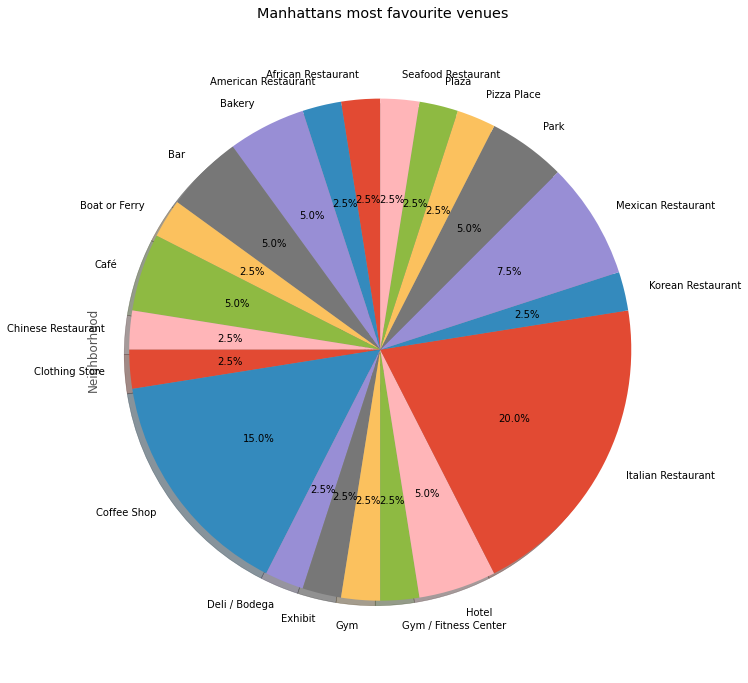

In [398]:
manhattan_top['Neighborhood'].plot(kind='pie', figsize=(10,12), autopct='%1.1f%%', startangle=90, shadow=True)

plt.title('Manhattans most favourite venues')
plt.axis('equal')

plt.show()

# Toronto: Top Venues

### Repeating the same steps of creating a dataframe using base data and visualising the data using pie chart for Toronto

In [413]:
num_top_venues=1

indicators=['st', 'nd', 'rd']

columns=['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
toronto_top_venues_sorted=pd.DataFrame(columns=columns)
toronto_top_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_top_venues_sorted.iloc[ind, 1:]= return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
toronto_top_venues_sorted.head()


,Neighborhood,Most Common Venue
0,Berczy Park,Coffee Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café
2,"Business reply mail Processing Centre, South C...",Yoga Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge
4,Central Bay Street,Coffee Shop


In [414]:
toronto_top=toronto_top_venues_sorted.groupby('Most Common Venue').count()

print(toronto_top.dtypes)
toronto_top.head()

Neighborhood    int64
dtype: object


,Neighborhood
Most Common Venue,
Airport Lounge,1
Asian Restaurant,1
Bakery,1
Bar,1
Breakfast Spot,1


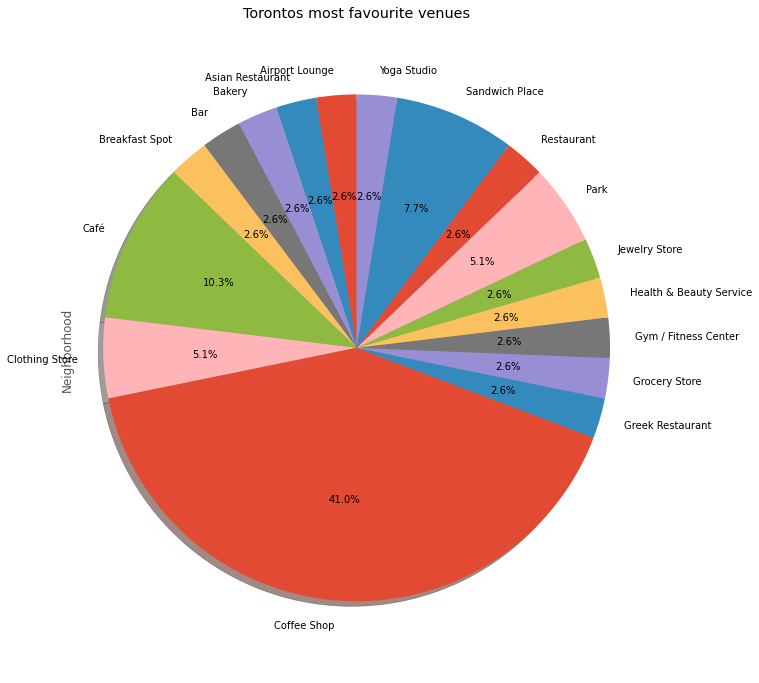

In [415]:
toronto_top['Neighborhood'].plot(kind='pie', figsize=(10,12), autopct='%1.1f%%', startangle=90, shadow=True)

plt.title('Torontos most favourite venues')
plt.axis('equal')

plt.show()